In [53]:
import json
import pandas as pd

import numpy as np
from dateutil import parser as dtparser
from datetime import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
#Reading the json file
url='logins2.json'
df = pd.read_json(url, orient='columns')
df.head()

,login_time
0,2010-01-01 00:11:52
1,2010-01-01 00:13:00
2,2010-01-01 00:14:49
3,2010-01-01 00:21:00
4,2010-01-01 00:23:05


In [64]:
#Aggregating to 15 minute intervals
df.index=df['login_time']
df1=(pd.DataFrame())
df1['count']=df.login_time.resample('15Min',label='right').count()
df1.head()

,count
login_time,
2010-01-01 00:15:00,3
2010-01-01 00:30:00,3
2010-01-01 00:45:00,7
2010-01-01 01:00:00,7
2010-01-01 01:15:00,5


In [65]:

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

In [67]:
#Splitting data into train and test
def split_dataset(data):
    
    train, test = data[0:20352], data[20352:]
    # restructure into windows of hourly data
    train = array(split(train, len(train)/4))
    
    test = array(split(test, len(test)/4))
    return train, test

In [71]:
#Convert train and test to sequences
def to_supervised(train, n_input, n_out=4):
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0

    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])

        in_start += 1
    return array(X), array(y)
 
# build the model
def build_model(train, n_steps, n_length, n_input):

    train_x, train_y = to_supervised(train, n_input)
    train_x.shape 

    verbose, epochs, batch_size = 1, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(300, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')

    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model
 
# make a forecast
def forecast(model, history, n_steps, n_length, n_input):

    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

    input_x = data[-n_input:, 0]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))

    yhat = model.predict(input_x, verbose=0)

    yhat = yhat[0]
    return yhat
 
# give predictions
def predict1(train, test, n_steps, n_length, n_input):

    model = build_model(train, n_steps, n_length, n_input)
    print(model.summary())
    
    
    history = [x for x in train]

    predictions = list()
    for i in range(len(test)):

        yhat_sequence = forecast(model, history, n_steps, n_length, n_input)      
        predictions.append(yhat_sequence)
        history.append(test[i, :])

    
    predictions = array(predictions)

    return predictions
 


train, test = split_dataset(df1.values)
n_steps, n_length = 3, 4
n_input = n_length * n_steps
predictions = predict1(train, test, n_steps, n_length, n_input)


Epoch 1/20
20336/20336 [==============================] - 55s 3ms/step - loss: 5.5436
Epoch 2/20
20336/20336 [==============================] - 51s 3ms/step - loss: 5.0938
Epoch 3/20
20336/20336 [==============================] - 51s 3ms/step - loss: 5.0857
Epoch 4/20
20336/20336 [==============================] - 44s 2ms/step - loss: 5.0750
Epoch 5/20
20336/20336 [==============================] - 52s 3ms/step - loss: 5.0710
Epoch 6/20
20336/20336 [==============================] - 55s 3ms/step - loss: 5.0550
Epoch 7/20
20336/20336 [==============================] - 57s 3ms/step - loss: 5.0546
Epoch 8/20
20336/20336 [==============================] - 50s 2ms/step - loss: 5.0471
Epoch 9/20
20336/20336 [==============================] - 39s 2ms/step - loss: 5.0339
Epoch 10/20
20336/20336 [==============================] - 39s 2ms/step - loss: 5.0263
Epoch 11/20
20336/20336 [==============================] - 39s 2ms/step - loss: 5.0212
Epoch 12/20
20336/20336 [===========================

In [72]:
predictions

array([[[5.905087 ],
        [6.043922 ],
        [5.802685 ],
        [5.7064905]],

       [[5.9940863],
        [6.0923743],
        [5.69702  ],
        [5.5591583]],

       [[6.0200324],
        [6.1096053],
        [5.8124943],
        [5.7069173]],

       ...,

       [[3.1839068],
        [2.9123094],
        [3.1327574],
        [3.2865908]],

       [[3.7980902],
        [3.7748082],
        [3.9808464],
        [4.077849 ]],

       [[2.2795498],
        [2.2505107],
        [2.3179996],
        [2.364734 ]]], dtype=float32)

In [73]:
#Calculating RMSE
prf=predictions.astype(int)
d = prf.flat
pr=list(d)

ac=test[:, :, 0]
d1=ac.flat
act=list(d1)

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(act, pr))

print(rms)

2.0957473279823353


/Users/tbanerjee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tbanerjee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<Figure size 432x288 with 0 Axes>

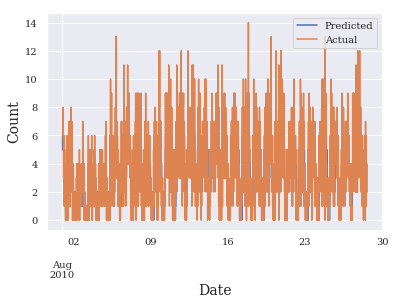

In [74]:
#Actual vs Predicted
df2=df1.iloc[20352:]
df2['Predicted']=pr
df2['Actual']=act
df2=df2.drop(['count'],axis=1)
plot=df2.plot()
plt.xlabel('Date', fontname = 'serif', fontsize = 14)
plt.ylabel('Count', fontname = 'serif', fontsize = 14)

plt.show()